# Seq2Seq - Encoder/Decoder networks
In this exercise we'll have a deeper look into the ability to use multiple RNN's to infer and generate sequences of data.
Specifically we will implement a Encoder-Decoder RNN based for a simple sequence to sequence translation task.
This type of models have shown impressive performance in Neural Machine Translation and Image Caption generation. 

In the encoder-decoder structure one RNN (blue) encodes the input into a hidden representation, and a second RNN (red) uses this representation to predict the target values.
An essential step is deciding how the encoder and decoder should communicate.
In the simplest approach you use the last hidden state of the encoder to initialize the decoder.
This is what we will do in this notebook, as shown here:

![](./images/enc-dec.png)

In this exercise we will translate from the words of number (e.g. 'nine') to the actual number (e.g. '9').
The input for the Encoder RNN consists of words defining the number, whilst the output of such an encoding serves as input for the Decoder RNN that aims to generate generate a number. 
Our dataset is generated and consists of numbers and an End-of-Sentence (EOS) character ('#'). The data we want to generate should be like follows:

```
Examples: 
prediction  |  input
991136#00 	 nine nine one one three six
81771#000 	 eight one seven seven one
3519614#0 	 three five one nine six one four
26656#000 	 two six six five six
60344#000 	 six zero three four four
162885#00 	 one six two eight eight five
78612625# 	 seven eight six one two six two five
9464710#0 	 nine four six four seven one zero
191306#00 	 one nine one three zero six
10160378# 	 one zero one zero six three seven eight
```

Let us define the space of characters and numbers to be learned with the networks:

```
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	' '=11,	'e'=12,	'g'=13,	'f'=14,	'i'=15,	'h'=16,	'o'=17,	'n'=18,	's'=19,	'r'=20,	'u'=21,	't'=22,	'w'=23,	'v'=24,	'x'=25,	'z'=26,	
Stop/start character = #
```

All represented characters and numbers as characters, gets mapped to an integer from 0-26. Our total space of valid characters consists of 27.

In [64]:
from data_generator import generate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np

from data_generator import generate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

NUM_INPUTS = 27 #No. of possible characters
NUM_OUTPUTS = 11  # (0-9 + '#')

### Hyperparameters and general configs
MAX_SEQ_LEN = 8
MIN_SEQ_LEN = 5
BATCH_SIZE = 8
TRAINING_SIZE = 8000
LEARNING_RATE = 0.003

# Hidden size of enc and dec need to be equal if last hidden of encoder becomes init hidden of decoder
# Otherwise we would need e.g. a linear layer to map to a space with the correct dimension
NUM_UNITS_ENC = NUM_UNITS_DEC = 48
TEST_SIZE = 200
EPOCHS = 10
TEACHER_FORCING = False

assert TRAINING_SIZE % BATCH_SIZE == 0

Device in use: cuda


For this exercise we won´t worry about data generation, but utilise a built function for this purpose. The function generates random data constained by the 27 characters described above.

The encoder takes as input the embedded text strings generated from the *generate* function as given here above ie. 'nine' would become [18 15 18 12].
Sequeneces are generated at random given settings of minima and maxima length, constrained by the dimensions of the two RNN´s architecture.
We may visualise a subset of the data generated by running the command below

In [19]:
!python3 ./data_generator.py

Generated batch length 3 from 3 iterations
input types: int32 int32 int32 int32 int32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	'n'=11,	's'=12,	'v'=13,	'w'=14,	'e'=15,	'i'=16,	'f'=17,	' '=18,	'o'=19,	't'=20,	'z'=21,	'h'=22,	'r'=23,	'g'=24,	'u'=25,	'x'=26,	
Stop/start character = #

SAMPLE 0
TEXT INPUTS:			 zero five four
ENCODED INPUTS:			 [21 15 23 19 18 17 16 13 15 18 17 19 25 23]
INPUTS SEQUENCE LENGTH:	 14
TEXT TARGETS INPUT:		 #054
TEXT TARGETS OUTPUT:	 054#
ENCODED TARGETS INPUT:	 [10  0  5  4]
ENCODED TARGETS OUTPUT:	 [ 0  5  4 10]
TARGETS SEQUENCE LENGTH: 4
TARGETS MASK:			 [1. 1. 1. 1.]

SAMPLE 1
TEXT INPUTS:			 four six eight
ENCODED INPUTS:			 [17 19 25 23 18 12 16 26 18 15 16 24 22 20]
INPUTS SEQUENCE LENGTH:	 14
TEXT TARGETS INPUT:		 #468
TEXT TARGETS OUTPUT:	 468#
ENCODED TARGETS INPUT:	 [10  4  6  8]
ENCODED TARGETS OUTPUT:	 [ 4  6  8 10]
TARGETS SEQUENCE LENGTH: 4
TARGETS MASK:			 [1. 1. 1. 1.]

SAMPLE 2

## Let's define the two RNN's



In [102]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, self.hidden_size)
        rnn = nn.GRU
        self.rnn = rnn(self.hidden_size, self.hidden_size, batch_first=True)

    def forward(self, inputs, hidden):
        # Input shape [batch, seq_in_len]z
        inputs = inputs.long()

        # Embedded shape [batch, seq_in_len, embed]
        embedded = self.embedding(inputs)
        
        # Output shape [batch, seq_in_len, embed]
        # Hidden shape [1, batch, embed], last hidden state of the GRU cell
        # We will feed this last hidden state into the decoder
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size):
        init = torch.zeros(1, batch_size, self.hidden_size, device=device)
        return init


In [103]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        rnn = nn.GRU
        self.rnn = rnn(self.hidden_size, self.hidden_size, batch_first=True)

    def forward(self, inputs, hidden, output_len, teacher_forcing=False):
        # Input shape: [batch, output_len]
        # Hidden shape: [seq_len=1, batch_size, hidden_dim] (the last hidden state of the encoder)

        if teacher_forcing:
            dec_input = inputs
            embed = self.embedding(dec_input)   # shape [batch, output_len, hidden_dim]
            out, hidden = self.rnn(embed, hidden)
            out = self.out(out)  # linear layer, out has now shape [batch, output_len, output_size]
            output = F.log_softmax(out, -1)
        else:
            # Take the EOS character only, for the whole batch, and unsqueeze so shape is [batch, 1]
            # This is the first input, then we will use as input the GRU output at the previous time step
            dec_input = inputs[:, 0].unsqueeze(1)

            output = []
            for i in range(output_len):
                #print(dec_input.dtype)
                #print(hidden)
                out, hidden = self.rnn(self.embedding(dec_input), hidden)
                out = self.out(out)  # linear layer, out has now shape [batch, 1, output_size]
                out = F.log_softmax(out, -1)
                output.append(out.squeeze(1))
                out_symbol = torch.argmax(out, dim=2)   # shape [batch, 1]
                dec_input = out_symbol   # feed the decoded symbol back into the recurrent unit at next step

            output = torch.stack(output).permute(1, 0, 2)  # [batch_size x seq_len x output_size]

        return output

The learned representation from the *Encoder* gets propagated to the *Decoder* as the final hidden layer in the *Encoder* network is set as initialisation for the *Decoder*'s first hidden layer.

In [104]:
def forward_pass(encoder, decoder, x, t, t_in, criterion, max_t_len, teacher_forcing):
    """
    Executes a forward pass through the whole model.

    :param encoder:
    :param decoder:
    :param x: input to the encoder, shape [batch, seq_in_len]
    :param t: target output predictions for decoder, shape [batch, seq_t_len]
    :param criterion: loss function
    :param max_t_len: maximum target length

    :return: output (after log-softmax), loss, accuracy (per-symbol)
    """
    # Run encoder and get last hidden state (and output)
    batch_size = x.size(0)
    enc_h = encoder.init_hidden(batch_size)
    enc_out, enc_h = encoder(x, enc_h)

    dec_h = enc_h  # Init hidden state of decoder as hidden state of encoder
    dec_input = t_in
    out = decoder(dec_input, dec_h, max_t_len, teacher_forcing)
    out = out.permute(0, 2, 1)
    # Shape: [batch_size x num_classes x out_sequence_len], with second dim containing log probabilities

    loss = criterion(out, t)
    pred = get_pred(log_probs=out)
    accuracy = (pred == t).type(torch.FloatTensor).mean()
    return out, loss, accuracy


In [105]:
def train(encoder, decoder, inputs, targets, targets_in, criterion, enc_optimizer, dec_optimizer, epoch, max_t_len):
    encoder.train()
    decoder.train()
    losses=[]
    accuracys = []
    for batch_idx, (x, t, t_in) in enumerate(zip(inputs, targets, targets_in)):
        
        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        
        output, loss, accuracy = forward_pass(encoder, decoder, x.long().cuda(), t.long().cuda(), t_in.long().cuda(), criterion, max_t_len, TEACHER_FORCING)
        # INSERT YOUR CODE HERE
        
        losses.append(loss)
        accuracys.append(accuracy)
        
        loss.backward()
        
        enc_optimizer.step()
        dec_optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Epoch {} [{}/{} ({:.0f}%)]\tTraining loss: {:.4f} \tTraining accuracy: {:.1f}%'.format(
                epoch, batch_idx * len(x), TRAINING_SIZE,
                100. * batch_idx * len(x) / TRAINING_SIZE, loss.item(),
                100. * accuracy.item()))
    return losses, accuracys

In [106]:
def test(encoder, decoder, inputs, targets, targets_in, criterion, max_t_len):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        targets = targets.long().to(device)
        targets_in = targets_in.long().to(device)
        out, loss, accuracy = forward_pass(encoder, decoder, inputs, targets, targets_in, criterion, max_t_len,
                                           teacher_forcing=TEACHER_FORCING)
    return out, loss, accuracy

In [107]:
def numbers_to_text(seq):
    return "".join([str(to_np(i)) if to_np(i) != 10 else '#' for i in seq])

def to_np(x):
    return x.cpu().numpy()

def get_pred(log_probs):
    """
    Get class prediction (digit prediction) from the net's output (the log_probs)
    :param log_probs: Tensor of shape [batch_size x n_classes x sequence_len]
    :return:
    """
    return torch.argmax(log_probs, dim=1)

Generated batch length 8000 from 8000 iterations
Generated batch length 200 from 202 iterations
Epoch 1 [0/8000 (0%)]	Training loss: 2.4063 	Training accuracy: 6.9%
Epoch 1 [1600/8000 (20%)]	Training loss: 1.8327 	Training accuracy: 27.8%
Epoch 1 [3200/8000 (40%)]	Training loss: 1.5520 	Training accuracy: 44.4%
Epoch 1 [4800/8000 (60%)]	Training loss: 1.3765 	Training accuracy: 55.6%
Epoch 1 [6400/8000 (80%)]	Training loss: 1.5922 	Training accuracy: 34.7%

Test set: Average loss: 1.3359 	Accuracy: 50.111%

Examples: prediction | input
11111111# 	 zero zero one one five one nine one
2333335#0 	 three two one five five eight four
7777777## 	 seven four seven five three seven eight eight
883338888 	 nine three three eight one five seven eight
044444#00 	 seven four zero five four four
97977#000 	 nine zero two seven seven
99993#000 	 zero four nine three six
33335#000 	 five three three seven five
0000933#0 	 zero zero seven five three three nine
6666666#0 	 eight six six six one six fou

Epoch 10 [1600/8000 (20%)]	Training loss: 0.7897 	Training accuracy: 68.1%
Epoch 10 [3200/8000 (40%)]	Training loss: 0.6595 	Training accuracy: 65.3%
Epoch 10 [4800/8000 (60%)]	Training loss: 0.4738 	Training accuracy: 79.2%
Epoch 10 [6400/8000 (80%)]	Training loss: 0.5421 	Training accuracy: 77.8%

Test set: Average loss: 0.5633 	Accuracy: 76.944%

Examples: prediction | input
00115111# 	 zero zero one one five one nine one
3415582#0 	 three two one five five eight four
74777888# 	 seven four seven five three seven eight eight
33155578# 	 nine three three eight one five seven eight
047544#00 	 seven four zero five four four
09297#000 	 nine zero two seven seven
03946#000 	 zero four nine three six
33355#000 	 five three three seven five
0735339#0 	 zero zero seven five three three nine
86661646# 	 eight six six six one six four six



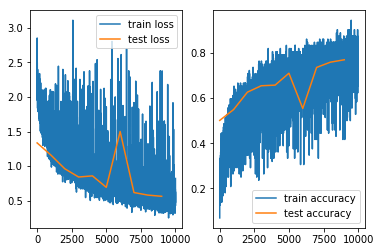

In [110]:
LEARNING_RATE = 0.003
encoder = EncoderRNN(NUM_INPUTS, NUM_UNITS_ENC).to(device)
decoder = DecoderRNN(NUM_UNITS_DEC, NUM_OUTPUTS).to(device)
enc_optimizer = optim.RMSprop(encoder.parameters(), lr=LEARNING_RATE)
dec_optimizer = optim.RMSprop(decoder.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss()

# Get training set
inputs, _, targets_in, targets, targets_seqlen, _, _, _, text_targ = generate(TRAINING_SIZE, min_len=MIN_SEQ_LEN, max_len=MAX_SEQ_LEN)
max_target_len = max(targets_seqlen)
inputs = torch.tensor(inputs)
targets = torch.tensor(targets)
targets_in = torch.tensor(targets_in)
unique_text_targets = set(text_targ)

# Get validation set
val_inputs, _, val_targets_in, val_targets, val_targets_seqlen, _, val_text_in, _, val_text_targ = \
    generate(TEST_SIZE, min_len=MIN_SEQ_LEN, max_len=MAX_SEQ_LEN, invalid_set=unique_text_targets)
val_inputs = torch.tensor(val_inputs)
val_targets = torch.tensor(val_targets)
val_targets_in = torch.tensor(val_targets_in)
max_val_target_len = max(val_targets_seqlen)
test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)

# Split training set in batches
inputs = [inputs[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]
targets = [targets[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]
targets_in = [targets_in[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]

loss_train = []
loss_test = []
accuracy_train= []
accuracy_test = []

# Quick and dirty - just loop over training set without reshuffling
for epoch in range(1, EPOCHS + 1):
    loss_train_i, accuracy_train_i = train(encoder, decoder, inputs, targets, targets_in, criterion, enc_optimizer, dec_optimizer, epoch, max_target_len)
    loss_train.extend(loss_train_i)
    accuracy_train.extend(accuracy_train_i)
    
    _, loss, accuracy = test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)
    print('\nTest set: Average loss: {:.4f} \tAccuracy: {:.3f}%\n'.format(loss, accuracy.item()*100.))

    loss_test.append(loss)
    accuracy_test.append(accuracy)
    
    # Show examples
    print("Examples: prediction | input")
    out, _, _ = test(encoder, decoder, val_inputs[:10], val_targets[:10], val_targets_in[:10], criterion, max_val_target_len)
    pred = get_pred(out)
    pred_text = [numbers_to_text(sample) for sample in pred]
    for i in range(10):
        print(pred_text[i], "\t", val_text_in[i])
    print()

plt.subplot(1, 2, 1)
plt.plot(np.arange(0,10000),loss_train, label='train loss')
plt.plot(np.arange(0,10000,1000),loss_test, label='test loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0,10000),accuracy_train, label='train accuracy')
plt.plot(np.arange(0,10000,1000),accuracy_test, label='test accuracy')

plt.legend()

# Exercise:

1. Implement missing code for the network in the *train* function. 
2. These networks implement the GRU-gates. Implement an alternative control utilising a memory mechanism (Hint: LSTM). What do you experience? 
3. (optional) There are some parameters in the model that may be optimized further, what could they be? Achieve >90% validation accuracy.

In [111]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, self.hidden_size)
        rnn = nn.LSTM
        self.rnn = rnn(self.hidden_size, self.hidden_size, batch_first=True)

    def forward(self, inputs, hidden, cn):
        # Input shape [batch, seq_in_len]z
        inputs = inputs.long()

        # Embedded shape [batch, seq_in_len, embed]
        embedded = self.embedding(inputs)
        
        # Output shape [batch, seq_in_len, embed]
        # Hidden shape [1, batch, embed], last hidden state of the GRU cell
        # We will feed this last hidden state into the decoder
        output, (hidden, cn) = self.rnn(embedded, (hidden, cn))
        return output, hidden, cn

    def init_hidden(self, batch_size):
        init = torch.zeros(1, batch_size, self.hidden_size, device=device)
        return init
    
class DecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        rnn = nn.LSTM
        self.rnn = rnn(self.hidden_size, self.hidden_size, batch_first=True)

    def forward(self, inputs, hidden, cn, output_len, teacher_forcing=False):
        # Input shape: [batch, output_len]
        # Hidden shape: [seq_len=1, batch_size, hidden_dim] (the last hidden state of the encoder)

        if teacher_forcing:
            dec_input = inputs
            embed = self.embedding(dec_input)   # shape [batch, output_len, hidden_dim]
            out, hidden = self.rnn(embed, hidden, cn)
            out = self.out(out)  # linear layer, out has now shape [batch, output_len, output_size]
            output = F.log_softmax(out, -1)
        else:
            # Take the EOS character only, for the whole batch, and unsqueeze so shape is [batch, 1]
            # This is the first input, then we will use as input the GRU output at the previous time step
            dec_input = inputs[:, 0].unsqueeze(1)

            output = []
            for i in range(output_len):

                out, (hidden, cn) = self.rnn(self.embedding(dec_input), (hidden,cn))
                out = self.out(out)  # linear layer, out has now shape [batch, 1, output_size]
                out = F.log_softmax(out, -1)
                output.append(out.squeeze(1))
                out_symbol = torch.argmax(out, dim=2)   # shape [batch, 1]
                dec_input = out_symbol   # feed the decoded symbol back into the recurrent unit at next step

            output = torch.stack(output).permute(1, 0, 2)  # [batch_size x seq_len x output_size]

        return output

In [112]:
def forward_pass(encoder, decoder, x, t, t_in, criterion, max_t_len, teacher_forcing):
    """
    Executes a forward pass through the whole model.

    :param encoder:
    :param decoder:
    :param x: input to the encoder, shape [batch, seq_in_len]
    :param t: target output predictions for decoder, shape [batch, seq_t_len]
    :param criterion: loss function
    :param max_t_len: maximum target length

    :return: output (after log-softmax), loss, accuracy (per-symbol)
    """
    # Run encoder and get last hidden state (and output)
    batch_size = x.size(0)
    enc_h, enc_cn = encoder.init_hidden(batch_size),encoder.init_hidden(batch_size)
    enc_out, enc_h, enc_cn = encoder(x, enc_h, enc_cn)

    dec_h = enc_h  # Init hidden state of decoder as hidden state of encoder
    dec_cn = enc_cn
    dec_input = t_in
    out = decoder(dec_input, dec_h, dec_cn, max_t_len, teacher_forcing)
    out = out.permute(0, 2, 1)
    # Shape: [batch_size x num_classes x out_sequence_len], with second dim containing log probabilities

    loss = criterion(out, t)
    pred = get_pred(log_probs=out)
    accuracy = (pred == t).type(torch.FloatTensor).mean()
    return out, loss, accuracy

Epoch 1 [0/8000 (0%)]	Training loss: 2.4423 	Training accuracy: 5.6%
Epoch 1 [1600/8000 (20%)]	Training loss: 1.8711 	Training accuracy: 33.3%
Epoch 1 [3200/8000 (40%)]	Training loss: 1.7000 	Training accuracy: 36.1%
Epoch 1 [4800/8000 (60%)]	Training loss: 1.5865 	Training accuracy: 34.7%
Epoch 1 [6400/8000 (80%)]	Training loss: 1.7164 	Training accuracy: 34.7%

Test set: Average loss: 1.7494 	Accuracy: 35.056%

Examples: prediction | input
292911111 	 zero zero one one five one nine one
2222288#0 	 three two one five five eight four
833333333 	 seven four seven five three seven eight eight
33737777# 	 nine three three eight one five seven eight
5033330#0 	 seven four zero five four four
69977#000 	 nine zero two seven seven
30750#000 	 zero four nine three six
30777#000 	 five three three seven five
5077777#0 	 zero zero seven five three three nine
50922228# 	 eight six six six one six four six

Epoch 2 [0/8000 (0%)]	Training loss: 1.5686 	Training accuracy: 37.5%
Epoch 2 [1600/8000 

Epoch 10 [1600/8000 (20%)]	Training loss: 0.3471 	Training accuracy: 83.3%
Epoch 10 [3200/8000 (40%)]	Training loss: 0.3591 	Training accuracy: 84.7%
Epoch 10 [4800/8000 (60%)]	Training loss: 0.2236 	Training accuracy: 95.8%
Epoch 10 [6400/8000 (80%)]	Training loss: 0.3089 	Training accuracy: 90.3%

Test set: Average loss: 0.3142 	Accuracy: 88.611%

Examples: prediction | input
00115191# 	 zero zero one one five one nine one
3215584#0 	 three two one five five eight four
74437788# 	 seven four seven five three seven eight eight
93387778# 	 nine three three eight one five seven eight
740444#00 	 seven four zero five four four
90277#000 	 nine zero two seven seven
04936#000 	 zero four nine three six
53375#000 	 five three three seven five
0075339#0 	 zero zero seven five three three nine
86611446# 	 eight six six six one six four six



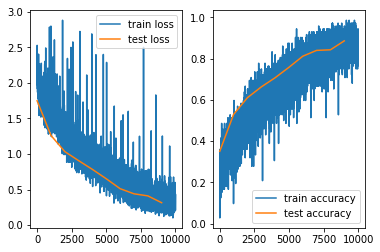

In [113]:
EPOCHS = 10
encoder = EncoderLSTM(NUM_INPUTS, NUM_UNITS_ENC).to(device)
decoder = DecoderLSTM(NUM_UNITS_DEC, NUM_OUTPUTS).to(device)
enc_optimizer = optim.RMSprop(encoder.parameters(), lr=LEARNING_RATE)
dec_optimizer = optim.RMSprop(decoder.parameters(), lr=LEARNING_RATE)
# Quick and dirty - just loop over training set without reshuffling


loss_train = []
loss_test = []
accuracy_train= []
accuracy_test = []

# Quick and dirty - just loop over training set without reshuffling
for epoch in range(1, EPOCHS + 1):
    loss_train_i, accuracy_train_i = train(encoder, decoder, inputs, targets, targets_in, criterion, enc_optimizer, dec_optimizer, epoch, max_target_len)
    loss_train.extend(loss_train_i)
    accuracy_train.extend(accuracy_train_i)
    
    _, loss, accuracy = test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)
    print('\nTest set: Average loss: {:.4f} \tAccuracy: {:.3f}%\n'.format(loss, accuracy.item()*100.))

    loss_test.append(loss)
    accuracy_test.append(accuracy)
    
    # Show examples
    print("Examples: prediction | input")
    out, _, _ = test(encoder, decoder, val_inputs[:10], val_targets[:10], val_targets_in[:10], criterion, max_val_target_len)
    pred = get_pred(out)
    pred_text = [numbers_to_text(sample) for sample in pred]
    for i in range(10):
        print(pred_text[i], "\t", val_text_in[i])
    print()

plt.subplot(1, 2, 1)
plt.plot(np.arange(0,10000),loss_train, label='train loss')
plt.plot(np.arange(0,10000,1000),loss_test, label='test loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0,10000),accuracy_train, label='train accuracy')
plt.plot(np.arange(0,10000,1000),accuracy_test, label='test accuracy')

plt.legend()

None of the networks have converged yet, so let's try to add some momentum, and increase the number of epochs

Epoch 1 [0/8000 (0%)]	Training loss: 2.4230 	Training accuracy: 4.2%
Epoch 1 [1600/8000 (20%)]	Training loss: 1.8039 	Training accuracy: 30.6%
Epoch 1 [3200/8000 (40%)]	Training loss: 1.7028 	Training accuracy: 33.3%
Epoch 1 [4800/8000 (60%)]	Training loss: 1.6952 	Training accuracy: 37.5%
Epoch 1 [6400/8000 (80%)]	Training loss: 1.6992 	Training accuracy: 37.5%

Test set: Average loss: 1.5619 	Accuracy: 41.333%

Examples: prediction | input
26666666# 	 zero zero one one five one nine one
979951##0 	 three two one five five eight four
78888888# 	 seven four seven five three seven eight eight
78888888# 	 nine three three eight one five seven eight
262000#00 	 seven four zero five four four
53377#000 	 nine zero two seven seven
20000#000 	 zero four nine three six
53777#000 	 five three three seven five
9779777#0 	 zero zero seven five three three nine
66666666# 	 eight six six six one six four six

Epoch 2 [0/8000 (0%)]	Training loss: 1.4110 	Training accuracy: 45.8%
Epoch 2 [1600/8000 

Epoch 10 [1600/8000 (20%)]	Training loss: 1.0240 	Training accuracy: 66.7%
Epoch 10 [3200/8000 (40%)]	Training loss: 0.8472 	Training accuracy: 69.4%
Epoch 10 [4800/8000 (60%)]	Training loss: 0.8094 	Training accuracy: 69.4%
Epoch 10 [6400/8000 (80%)]	Training loss: 0.9549 	Training accuracy: 61.1%

Test set: Average loss: 0.8675 	Accuracy: 68.000%

Examples: prediction | input
10111191# 	 zero zero one one five one nine one
6299584#0 	 three two one five five eight four
47777488# 	 seven four seven five three seven eight eight
99999578# 	 nine three three eight one five seven eight
774544#00 	 seven four zero five four four
12077#000 	 nine zero two seven seven
04036#000 	 zero four nine three six
33375#000 	 five three three seven five
7073339#0 	 zero zero seven five three three nine
66666646# 	 eight six six six one six four six

Epoch 11 [0/8000 (0%)]	Training loss: 0.7285 	Training accuracy: 75.0%
Epoch 11 [1600/8000 (20%)]	Training loss: 0.9653 	Training accuracy: 69.4%
Epoch 11

Epoch 19 [1600/8000 (20%)]	Training loss: 0.6162 	Training accuracy: 77.8%
Epoch 19 [3200/8000 (40%)]	Training loss: 0.4558 	Training accuracy: 83.3%
Epoch 19 [4800/8000 (60%)]	Training loss: 0.5249 	Training accuracy: 77.8%
Epoch 19 [6400/8000 (80%)]	Training loss: 0.6389 	Training accuracy: 75.0%

Test set: Average loss: 0.4528 	Accuracy: 82.333%

Examples: prediction | input
00111591# 	 zero zero one one five one nine one
8219984#0 	 three two one five five eight four
87573888# 	 seven four seven five three seven eight eight
33395588# 	 nine three three eight one five seven eight
740544#00 	 seven four zero five four four
00277#000 	 nine zero two seven seven
04936#000 	 zero four nine three six
53375#000 	 five three three seven five
0704939#0 	 zero zero seven five three three nine
96661646# 	 eight six six six one six four six

Epoch 20 [0/8000 (0%)]	Training loss: 0.3977 	Training accuracy: 83.3%
Epoch 20 [1600/8000 (20%)]	Training loss: 0.5241 	Training accuracy: 79.2%
Epoch 20

Epoch 28 [1600/8000 (20%)]	Training loss: 0.3728 	Training accuracy: 84.7%
Epoch 28 [3200/8000 (40%)]	Training loss: 0.2971 	Training accuracy: 86.1%
Epoch 28 [4800/8000 (60%)]	Training loss: 0.3085 	Training accuracy: 86.1%
Epoch 28 [6400/8000 (80%)]	Training loss: 0.4259 	Training accuracy: 81.9%

Test set: Average loss: 0.3190 	Accuracy: 87.889%

Examples: prediction | input
00111191# 	 zero zero one one five one nine one
8215584#0 	 three two one five five eight four
75330868# 	 seven four seven five three seven eight eight
33335578# 	 nine three three eight one five seven eight
740544#00 	 seven four zero five four four
00277#000 	 nine zero two seven seven
04936#000 	 zero four nine three six
53375#000 	 five three three seven five
0064339#0 	 zero zero seven five three three nine
86661646# 	 eight six six six one six four six

Epoch 29 [0/8000 (0%)]	Training loss: 0.1759 	Training accuracy: 93.1%
Epoch 29 [1600/8000 (20%)]	Training loss: 0.3506 	Training accuracy: 86.1%
Epoch 29

Epoch 37 [1600/8000 (20%)]	Training loss: 0.5015 	Training accuracy: 80.6%
Epoch 37 [3200/8000 (40%)]	Training loss: 0.2051 	Training accuracy: 88.9%
Epoch 37 [4800/8000 (60%)]	Training loss: 0.2127 	Training accuracy: 94.4%
Epoch 37 [6400/8000 (80%)]	Training loss: 0.5040 	Training accuracy: 83.3%

Test set: Average loss: 0.3043 	Accuracy: 89.389%

Examples: prediction | input
00111191# 	 zero zero one one five one nine one
3215984#0 	 three two one five five eight four
75703778# 	 seven four seven five three seven eight eight
33335978# 	 nine three three eight one five seven eight
740544#00 	 seven four zero five four four
00277#000 	 nine zero two seven seven
04936#000 	 zero four nine three six
53375#000 	 five three three seven five
0005339#0 	 zero zero seven five three three nine
86666446# 	 eight six six six one six four six

Epoch 38 [0/8000 (0%)]	Training loss: 0.1462 	Training accuracy: 95.8%
Epoch 38 [1600/8000 (20%)]	Training loss: 0.4396 	Training accuracy: 84.7%
Epoch 38

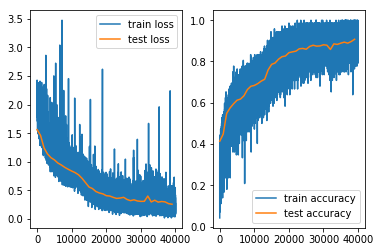

In [130]:
LEARNING_RATE=0.003
EPOCHS = 40
encoder = EncoderLSTM(NUM_INPUTS, NUM_UNITS_ENC).to(device)
decoder = DecoderLSTM(NUM_UNITS_DEC, NUM_OUTPUTS).to(device)
enc_optimizer = optim.RMSprop(encoder.parameters(), lr=LEARNING_RATE, momentum=0.1)
dec_optimizer = optim.RMSprop(decoder.parameters(), lr=LEARNING_RATE, momentum=0.1)
# Quick and dirty - just loop over training set without reshuffling


loss_train = []
loss_test = []
accuracy_train= []
accuracy_test = []

# Quick and dirty - just loop over training set without reshuffling
for epoch in range(1, EPOCHS + 1):
    loss_train_i, accuracy_train_i = train(encoder, decoder, inputs, targets, targets_in, criterion, enc_optimizer, dec_optimizer, epoch, max_target_len)
    loss_train.extend(loss_train_i)
    accuracy_train.extend(accuracy_train_i)
    
    _, loss, accuracy = test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)
    print('\nTest set: Average loss: {:.4f} \tAccuracy: {:.3f}%\n'.format(loss, accuracy.item()*100.))

    loss_test.append(loss)
    accuracy_test.append(accuracy)
    
    # Show examples
    print("Examples: prediction | input")
    out, _, _ = test(encoder, decoder, val_inputs[:10], val_targets[:10], val_targets_in[:10], criterion, max_val_target_len)
    pred = get_pred(out)
    pred_text = [numbers_to_text(sample) for sample in pred]
    for i in range(10):
        print(pred_text[i], "\t", val_text_in[i])
    print()

plt.subplot(1, 2, 1)
plt.plot(np.arange(0,1000*EPOCHS),loss_train, label='train loss')
plt.plot(np.arange(0,1000*EPOCHS,1000),loss_test, label='test loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(0,1000*EPOCHS),accuracy_train, label='train accuracy')
plt.plot(np.arange(0,1000*EPOCHS,1000),accuracy_test, label='test accuracy')

plt.legend()

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**
### Problem: The idea of convolutional layers is to behave in an invariant way across images. It may seem surprising, then, that our network can learn more when all we've done is translate the input data. Can you explain why this is actually quite reasonable?

By manipulating the data slightly, what we basically are doing, is implicitly adding some regularization. This is due to the fact that the more data you have, the more complex your model has to be in order to overfit. In this case, it could correspond to adding a slight amount of noise to the image, which should force the model to learn a more robust mapping. One might argue, that since we are using pooling, the model should not be effected by small translations. But since our max pool kernel is 2x2, there is a 50% change that the pixel will move to the neighbouring kernel. The change is small, but again, even a small amount of added noise should reduce overfitting 

